In [15]:
# SETUP to calculate moments

import argparse
import treegp
import numpy as np
import pandas as pd
import pickle
from datetime import datetime
from sklearn.gaussian_process.kernels import Kernel
import os
import treecorr

# plotting things
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

plt.rcParams["font.size"]=15
plt.rcParams["axes.labelsize"]=15

def comp_2pcf_treecorr(x, y, k, bin_type='TwoD'):
    """measure the anisotropic 2pcf of some data."""
    cat = treecorr.Catalog(x=x, y=y, k=k, w=None)
    kk = treecorr.KKCorrelation(min_sep=0, max_sep=0.15, nbins=17,
                                bin_type=bin_type, bin_slop=0)
    kk.process(cat)

    return kk.xi

def raw_moments(im, ordx=1, ordy=1):

    posY, posX = np.indices(im.shape)
    posY = np.flipud(posY)
    
    rmom = sum(sum(im*posX**ordx*posY**ordy))
    
    return rmom

def centroids(im):
    M10 = raw_moments(im, ordx=1, ordy=0)
    M00 = raw_moments(im, ordx=0, ordy=0)
    M01 = raw_moments(im, ordx=0, ordy=1)
    xbar = M10/M00
    ybar = M01/M00
    return xbar, ybar
    
def cent_moments(im, ordx=1, ordy=1):
    posY, posX = np.indices(im.shape)
    posY = np.flipud(posY)
    
    xbar, ybar = centroids(im)
    
    cmom = sum(sum(im*(posX-xbar)**ordx*(posY-ybar)**ordy))
    
    return cmom

def get_theta(g1, g2):
    # this give theta in degrees
    phi = np.arctan2(g2,g1)*180/np.pi
    if g1*g2> 0:
        #first, quadrant
        if g1 > 0:
            phi = phi
        #third quadrant
        else: 
            phi = phi+360
    # second quadrant
    elif g1 < 0 and g2 > 0:
        phi = phi
    # fouth quadrant
    elif g1 > 0 and g2 < 0:
        phi = phi+360 
    theta = phi/2
    return theta

def get_orient(im):
    xbar, ybar = centroids(im)
    M20 = raw_moments(im, ordx=2, ordy=0)
    M00 = raw_moments(im, ordx=0, ordy=0)
    M02 = raw_moments(im, ordx=0, ordy=2)
    M11 = raw_moments(im, ordx=1, ordy=1)
    
    mu20p = M20/M00 - xbar**2
    mu02p = M02/M00 - ybar**2
    mu11p = M11/M00 - xbar*ybar
    
    #angle in degrees
    theta = get_theta(mu20p-mu02p,2*mu11p)
    return theta

# this cell checks a fit case for psfws

In [2]:
def checkPsfws(seed):
    d = pickle.load(open("..//runsims//sameheightPsfws//outh_psfws_"+str(seed)+".pkl", 'rb'))
    for k in ['e1', 'e2', 'thx', 'thy', 'sigma']:
        locals()[k] = np.array(d[k])

    d_sigma = sigma - np.mean(sigma)
    xi_dsigma  = comp_2pcf_treecorr(thx, thy, d_sigma)

    fig, ax = plt.subplots(1,1)
    imag = ax.imshow(xi_dsigma, "Blues")
    divider = make_axes_locatable(ax)
    ax_cb = divider.append_axes("right", size="4%")
    cbar = plt.colorbar(imag, cax=ax_cb, orientation='vertical')
    cbar.formatter.set_powerlimits((0, 0))
    ax.set_xticks(np.linspace(0,16.5,5),np.linspace(-0.75,0.75,5))
    ax.set_yticks(np.linspace(0,16.5,5),np.linspace(-0.75,0.75,5))
    print("seed:  ",seed)
    print("angle: ",get_orient(xi_dsigma))


# get speeds and directions

In [4]:
seeds = list(range(6,11))+[22,23,25,26,27]+list(range(30,40))
seeds +=list(range(42,54))+list(range(55,61))+list(range(62,90))
seeds += list(range(90,171))
    
def getPara(path, seeds):
    speeds ={}
    directions ={}
    for seed in seeds:
        d = pickle.load(open(path+str(seed)+".pkl", 'rb'))
        speeds[seed] = d['atmKwargs']['speed']
        directions[seed] = [x.deg for x in d['atmKwargs']['direction']]
    return speeds, directions

pathP = "..//runsims//sameheightPsfws//outh_psfws_"
pathR = "..//runsims//sameheightRand//outh_rand_"
pathRM = "..//runsims//matchSpeedRand//outv_rand_"

speedsP, directionsP = getPara(pathP, seeds) 
speedsR, directionsR = getPara(pathR, seeds) 
speedsRM, directionsRM = getPara(pathRM, seeds) 


# parameter variances and 1st moment sums

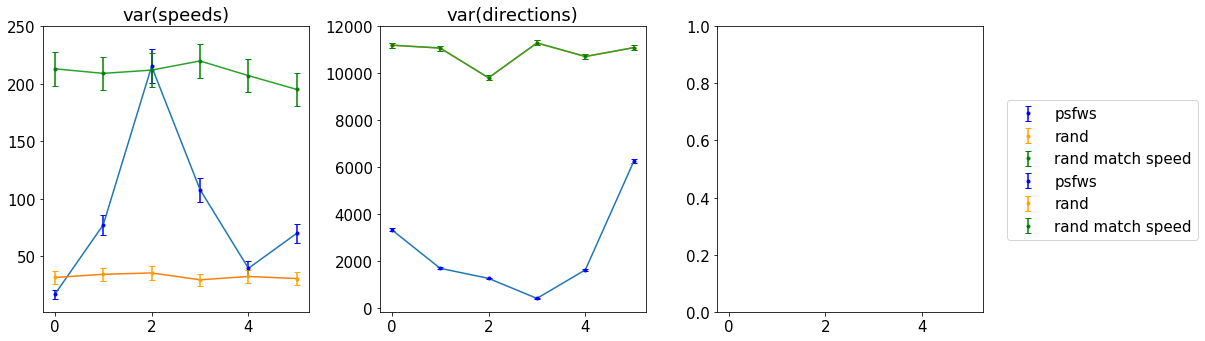

In [23]:
fig,ax = plt.subplots(1,3,figsize=(14,6), sharex=True)

def erbar(ax, x, y, clr, lbl):
    yerr = [y[i]**0.5 for i in range(len(y))]
    ax.errorbar(x, y, yerr,
                     marker = '.', drawstyle="steps-mid",
                     linestyle ="",capsize=3, color=clr, label=lbl)
    ax.plot(x,y)
    return ax

def pltVAR(ax, param, psfws=False, rand=False, randM = False):
    x = list(range(6))
    var = [np.var(pd.DataFrame(param).iloc[i]) for i in range(6)]
    if psfws: 
        ax = erbar(ax, x, var, "b", "psfws")
    elif rand: 
        ax= erbar(ax, x, var,"orange", "rand")
    elif randM: 
        ax = erbar(ax, x, var,"g", "rand match speed")
    return ax

ax[0,0] = pltVAR(ax[0,0], speedsP, psfws=True)
ax[0,0] = pltVAR(ax[0,0], speedsR,  rand=True)
ax[0,0] = pltVAR(ax[0,0], speedsRM,  randM=True)
ax[0,1] = pltVAR(ax[0,1], directionsP,  psfws=True)
ax[0,1] = pltVAR(ax[0,1], directionsR,  rand=True)
ax[0,1] = pltVAR(ax[0,1], directionsRM,  randM=True)
ax[0,0].set_ylim(ymax=250) 
ax[0,0].set_title("var(speeds)")
ax[0,1].set_ylim(ymax=12000) 
ax[0,1].set_title("var(directions)")




fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()

''

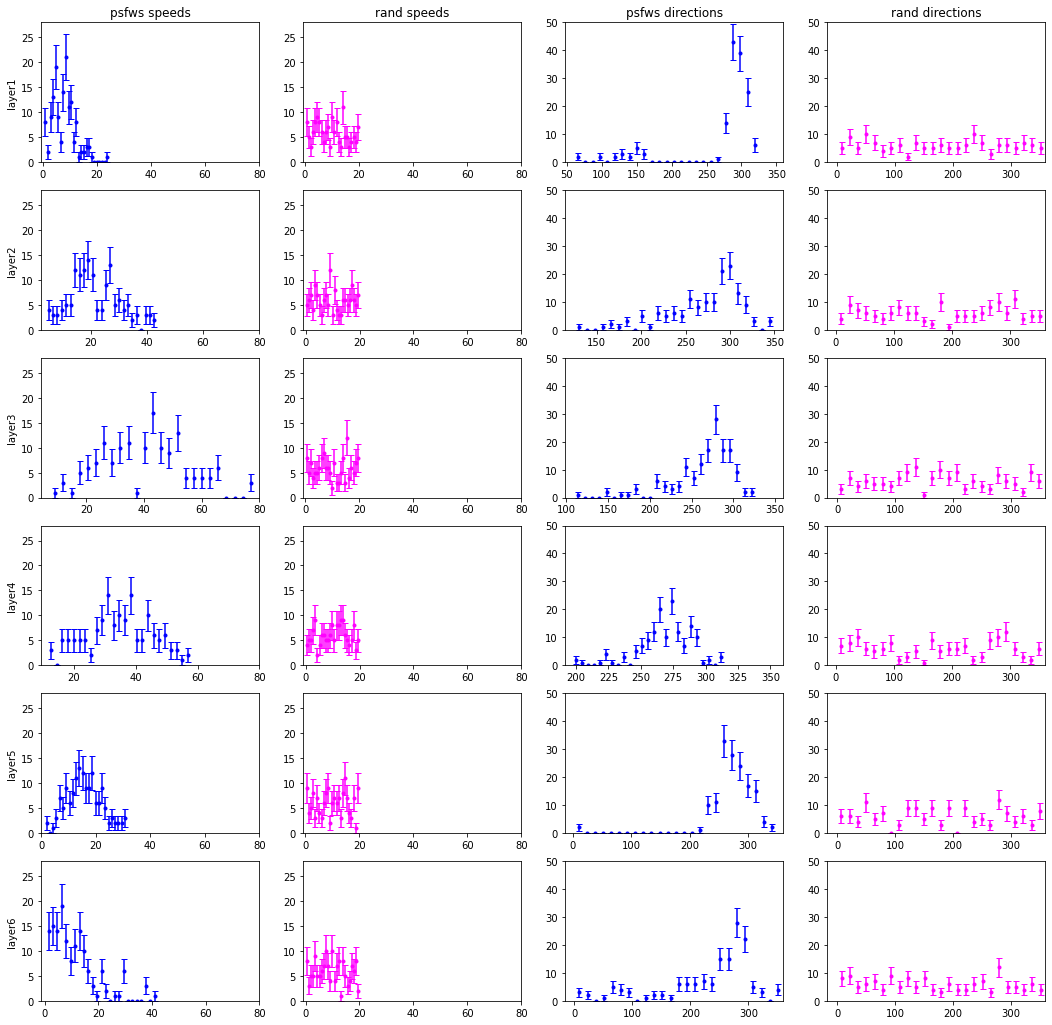

In [6]:
def plothist(ax,para,clr):
    y, bin_edges, _ = ax.hist(para, bins=25, histtype='step', color="white")
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    ax.errorbar(
        bin_centers,
        y,
        yerr = y**0.5,
        marker = '.', drawstyle="steps-mid",
        linestyle ="",capsize=3, color=clr)
    return ax

fig,ax = plt.subplots(6,4,figsize=(18,18))
[ax[i,0]==plothist(ax[i,0],pd.DataFrame(speedsP).iloc[i],"blue") for i in range(6)]
[ax[i,1]==plothist(ax[i,1],pd.DataFrame(speedsR).iloc[i],"magenta") for i in range(6)]
ax[0,0].set_title("psfws speeds")
ax[0,1].set_title("rand speeds")
[[ax[i,j].set_xlim(right=80) for i in range(6)] for j in [0,1]]
[[ax[i,j].set_ylim(top=28) for i in range(6)] for j in [0,1]]
[ax[i,0].set_ylabel("layer"+str(i+1)) for i in range(6)]

[ax[i,2]==plothist(ax[i,2],pd.DataFrame(directionsP).iloc[i],"blue") for i in range(6)]
[ax[i,3]==plothist(ax[i,3],pd.DataFrame(directionsR).iloc[i],"magenta") for i in range(6)]
ax[0,2].set_title("psfws directions")
ax[0,3].set_title("rand directions")
[[ax[i,j].set_xlim(right=360) for i in range(6)] for j in [2,3]]
[[ax[i,j].set_ylim(top=50) for i in range(6)] for j in [2,3]]
;